In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("3-STAGE LightGBM WITH OVERFITTING PREVENTION")
print("="*80)

# Load the data
df = pd.read_csv('/content/men_2026_matchups_training.csv')

# Example: Second Round games (adjust as needed)
df_filtered = df[df['round'] == 'Second Round'].copy()

print(f"\nTotal games: {len(df_filtered)}")
print(f"Class distribution:\n{df_filtered['win'].value_counts()}")

3-STAGE LightGBM WITH OVERFITTING PREVENTION

Total games: 320
Class distribution:
win
1    160
0    160
Name: count, dtype: int64


In [2]:
# Define features (use your feature list)
features = [
    '5man_bpm', 'kenpom_rtg', 'def_lineup_depth_quality', 'torvik_rtg',
    'kenpom_off', '3man_bpm', '5man_dbpm', 'lineup_depth_quality',
    '5man_obpm', 'kenpom_def', 'experience_weighted_production', 'wab',
    'defensive_versatility_score', 'four_factors_composite', 'torvik_def',
    '3man_obpm', 'off_3pt_fg_pct', 'def_four_factors_composite', 'torvik_off',
    'size_speed_index', 'def_size_speed_index', 'def_rim_efficiency',
    'def_experience_impact', 'efg_pct', 'offensive_versatility_score',
    'efgd_pct', '3pd_pct', 'def_3pt_fg_pct', 'blk_pct', 'blked_pct'
]

print(f"\nNumber of features: {len(features)}")

# Prepare X and y
X = df_filtered[features]
y = df_filtered['win']

# Handle missing values
X = X.fillna(X.median())

# Split: Train, Validation, Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.18, random_state=42, stratify=y_temp  # ~15% of original
)

print(f"\nTraining set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of features: 30

Training set: 223
Validation set: 49
Test set: 48


In [4]:
# Scale features (optional for LightGBM but can help)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
# =============================================================================
# CUSTOM LIGHTGBM WRAPPER WITH EARLY STOPPING
# =============================================================================
class LGBMWithEarlyStopping(lgb.LGBMClassifier):
    """LightGBM wrapper that uses early stopping during hyperparameter search"""

    def fit(self, X, y, **kwargs):
        # Check if we have validation data from RandomizedSearchCV
        if hasattr(self, '_val_data'):
            X_val, y_val = self._val_data

            return super().fit(
                X, y,
                eval_set=[(X, y), (X_val, y_val)],
                eval_names=['train', 'valid'],
                eval_metric='logloss',
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False),
                    lgb.log_evaluation(period=0)  # Disable logging during search
                ]
            )
        else:
            return super().fit(X, y)

    def set_validation_data(self, X_val, y_val):
        """Set validation data for early stopping"""
        self._val_data = (X_val, y_val)

In [6]:
# =============================================================================
# STAGE 1: BROAD SEARCH (500 iterations)
# =============================================================================
print("\n" + "="*80)
print("STAGE 1: BROAD HYPERPARAMETER SEARCH")
print("Iterations: 500 | CV Folds: 5 | Total Fits: 2,500")
print("="*80 + "\n")

# Conservative parameter distributions to prevent overfitting
param_distributions_stage1 = {
    # Learning rate - LOWER prevents overfitting
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],

    # Tree complexity - LIMIT to prevent overfitting
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'num_leaves': [15, 20, 31, 40, 50, 63],
    'min_child_samples': [10, 20, 30, 50, 70, 100],
    'min_child_weight': [0.001, 0.01, 0.1, 1.0],

    # Regularization - HIGHER prevents overfitting
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0, 5.0],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1.0, 5.0],

    # Sampling - LOWER prevents overfitting
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample_freq': [0, 1],

    # Other anti-overfitting parameters
    'min_split_gain': [0.0, 0.01, 0.05, 0.1],
    'max_bin': [127, 255, 511],

    # Number of estimators (will use early stopping)
    'n_estimators': [500, 1000, 1500]
}

lgbm_stage1 = LGBMWithEarlyStopping(
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

# Set validation data for early stopping
lgbm_stage1.set_validation_data(X_val_scaled, y_val)


STAGE 1: BROAD HYPERPARAMETER SEARCH
Iterations: 500 | CV Folds: 5 | Total Fits: 2,500



In [7]:
random_search_stage1 = RandomizedSearchCV(
    estimator=lgbm_stage1,
    param_distributions=param_distributions_stage1,
    n_iter=500,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage1_start = time.time()
random_search_stage1.fit(X_train_scaled, y_train)
stage1_time = time.time() - stage1_start

best_params_stage1 = random_search_stage1.best_params_

print(f"\n{'='*80}")
print(f"STAGE 1 COMPLETE - Time: {stage1_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage1.items():
    print(f"  {param}: {value}")

# Check for overfitting in Stage 1
stage1_train_score = random_search_stage1.best_estimator_.score(X_train_scaled, y_train)
stage1_val_score = random_search_stage1.best_estimator_.score(X_val_scaled, y_val)
print(f"\nStage 1 Overfitting Check:")
print(f"  Train accuracy: {stage1_train_score:.4f}")
print(f"  Validation accuracy: {stage1_val_score:.4f}")
print(f"  Gap: {stage1_train_score - stage1_val_score:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

STAGE 1 COMPLETE - Time: 16.3 minutes
Best CV Score: 0.7578

Best Parameters:
  subsample_freq: 1
  subsample: 0.8
  reg_lambda: 5.0
  reg_alpha: 0.1
  num_leaves: 20
  n_estimators: 500
  min_split_gain: 0.0
  min_child_weight: 1.0
  min_child_samples: 10
  max_depth: 6
  max_bin: 511
  learning_rate: 0.02
  colsample_bytree: 0.6

Stage 1 Overfitting Check:
  Train accuracy: 0.9865
  Validation accuracy: 0.8163
  Gap: 0.1702


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMWithEarlyStopping was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMWithEarlyStopping was fitted with feature names
  warnings.warn(


In [8]:
# =============================================================================
# STAGE 2: FOCUSED SEARCH (2,500 iterations)
# =============================================================================
print("\n" + "="*80)
print("STAGE 2: FOCUSED SEARCH AROUND BEST PARAMS")
print("Iterations: 2,500 | CV Folds: 5 | Total Fits: 12,500")
print("="*80 + "\n")

def get_range(value, options_list, expand_by=2):
    """Get a focused range around the best value"""
    if value is None:
        return [None]
    if value not in options_list:
        return [value]

    idx = options_list.index(value)
    start_idx = max(0, idx - expand_by)
    end_idx = min(len(options_list), idx + expand_by + 1)
    return options_list[start_idx:end_idx]

learning_rate_opts = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15]
max_depth_opts = [3, 4, 5, 6, 7, 8, 10, 12]
num_leaves_opts = [10, 15, 20, 25, 31, 40, 50, 63, 80]
min_child_samples_opts = [5, 10, 15, 20, 30, 50, 70, 100, 150]
min_child_weight_opts = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]
reg_alpha_opts = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
reg_lambda_opts = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
subsample_opts = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
colsample_bytree_opts = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
min_split_gain_opts = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2]
max_bin_opts = [127, 191, 255, 383, 511]
n_estimators_opts = [500, 750, 1000, 1500, 2000]


STAGE 2: FOCUSED SEARCH AROUND BEST PARAMS
Iterations: 2,500 | CV Folds: 5 | Total Fits: 12,500



In [9]:
param_distributions_stage2 = {
    'learning_rate': get_range(best_params_stage1['learning_rate'], learning_rate_opts, 3),
    'max_depth': get_range(best_params_stage1['max_depth'], max_depth_opts, 2),
    'num_leaves': get_range(best_params_stage1['num_leaves'], num_leaves_opts, 3),
    'min_child_samples': get_range(best_params_stage1['min_child_samples'], min_child_samples_opts, 3),
    'min_child_weight': get_range(best_params_stage1['min_child_weight'], min_child_weight_opts, 2),
    'reg_alpha': get_range(best_params_stage1['reg_alpha'], reg_alpha_opts, 3),
    'reg_lambda': get_range(best_params_stage1['reg_lambda'], reg_lambda_opts, 3),
    'subsample': get_range(best_params_stage1['subsample'], subsample_opts, 3),
    'colsample_bytree': get_range(best_params_stage1['colsample_bytree'], colsample_bytree_opts, 3),
    'subsample_freq': [best_params_stage1['subsample_freq']],
    'min_split_gain': get_range(best_params_stage1['min_split_gain'], min_split_gain_opts, 2),
    'max_bin': get_range(best_params_stage1['max_bin'], max_bin_opts, 1),
    'n_estimators': get_range(best_params_stage1['n_estimators'], n_estimators_opts, 1)
}

print(f"Stage 2 Search Space:")
for param, values in param_distributions_stage2.items():
    print(f"  {param}: {values}")

lgbm_stage2 = LGBMWithEarlyStopping(
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

lgbm_stage2.set_validation_data(X_val_scaled, y_val)

random_search_stage2 = RandomizedSearchCV(
    estimator=lgbm_stage2,
    param_distributions=param_distributions_stage2,
    n_iter=2500,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=43,
    return_train_score=True
)

stage2_start = time.time()
random_search_stage2.fit(X_train_scaled, y_train)
stage2_time = time.time() - stage2_start

Stage 2 Search Space:
  learning_rate: [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.07]
  max_depth: [4, 5, 6, 7, 8]
  num_leaves: [10, 15, 20, 25, 31, 40]
  min_child_samples: [5, 10, 15, 20, 30]
  min_child_weight: [0.01, 0.1, 1.0, 5.0]
  reg_alpha: [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
  reg_lambda: [0.5, 1.0, 2.0, 5.0, 10.0]
  subsample: [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
  colsample_bytree: [0.5, 0.6, 0.7, 0.75, 0.8]
  subsample_freq: [1]
  min_split_gain: [0.0, 0.001, 0.01]
  max_bin: [383, 511]
  n_estimators: [500, 750]
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


In [10]:
best_params_stage2 = random_search_stage2.best_params_

print(f"\n{'='*80}")
print(f"STAGE 2 COMPLETE - Time: {stage2_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage2.best_score_:.4f}")
print(f"Improvement from Stage 1: {random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage2.items():
    print(f"  {param}: {value}")

# Check for overfitting in Stage 2
stage2_train_score = random_search_stage2.best_estimator_.score(X_train_scaled, y_train)
stage2_val_score = random_search_stage2.best_estimator_.score(X_val_scaled, y_val)
print(f"\nStage 2 Overfitting Check:")
print(f"  Train accuracy: {stage2_train_score:.4f}")
print(f"  Validation accuracy: {stage2_val_score:.4f}")
print(f"  Gap: {stage2_train_score - stage2_val_score:.4f}")


STAGE 2 COMPLETE - Time: 87.1 minutes
Best CV Score: 0.7668
Improvement from Stage 1: 0.0090

Best Parameters:
  subsample_freq: 1
  subsample: 0.95
  reg_lambda: 1.0
  reg_alpha: 0.1
  num_leaves: 31
  n_estimators: 500
  min_split_gain: 0.01
  min_child_weight: 0.01
  min_child_samples: 10
  max_depth: 7
  max_bin: 511
  learning_rate: 0.015
  colsample_bytree: 0.5

Stage 2 Overfitting Check:
  Train accuracy: 1.0000
  Validation accuracy: 0.7755
  Gap: 0.2245


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMWithEarlyStopping was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMWithEarlyStopping was fitted with feature names
  warnings.warn(


In [11]:
# =============================================================================
# STAGE 3: FINE-TUNING (5,000 iterations)
# =============================================================================
print("\n" + "="*80)
print("STAGE 3: FINE-TUNING WITH 10-FOLD CV")
print("Iterations: 5,000 | CV Folds: 10 | Total Fits: 50,000")
print("="*80 + "\n")

param_distributions_stage3 = {
    'learning_rate': get_range(best_params_stage2['learning_rate'], learning_rate_opts, 2),
    'max_depth': get_range(best_params_stage2['max_depth'], max_depth_opts, 1),
    'num_leaves': get_range(best_params_stage2['num_leaves'], num_leaves_opts, 2),
    'min_child_samples': get_range(best_params_stage2['min_child_samples'], min_child_samples_opts, 2),
    'min_child_weight': get_range(best_params_stage2['min_child_weight'], min_child_weight_opts, 1),
    'reg_alpha': get_range(best_params_stage2['reg_alpha'], reg_alpha_opts, 2),
    'reg_lambda': get_range(best_params_stage2['reg_lambda'], reg_lambda_opts, 2),
    'subsample': get_range(best_params_stage2['subsample'], subsample_opts, 2),
    'colsample_bytree': get_range(best_params_stage2['colsample_bytree'], colsample_bytree_opts, 2),
    'subsample_freq': [best_params_stage2['subsample_freq']],
    'min_split_gain': get_range(best_params_stage2['min_split_gain'], min_split_gain_opts, 1),
    'max_bin': [best_params_stage2['max_bin']],
    'n_estimators': [best_params_stage2['n_estimators']]
}

print(f"Stage 3 Search Space:")
for param, values in param_distributions_stage3.items():
    print(f"  {param}: {values}")


STAGE 3: FINE-TUNING WITH 10-FOLD CV
Iterations: 5,000 | CV Folds: 10 | Total Fits: 50,000

Stage 3 Search Space:
  learning_rate: [0.005, 0.01, 0.015, 0.02, 0.03]
  max_depth: [6, 7, 8]
  num_leaves: [20, 25, 31, 40, 50]
  min_child_samples: [5, 10, 15, 20]
  min_child_weight: [0.001, 0.01, 0.1]
  reg_alpha: [0.01, 0.05, 0.1, 0.5, 1.0]
  reg_lambda: [0.1, 0.5, 1.0, 2.0, 5.0]
  subsample: [0.85, 0.9, 0.95, 1.0]
  colsample_bytree: [0.5, 0.6, 0.7]
  subsample_freq: [1]
  min_split_gain: [0.001, 0.01, 0.05]
  max_bin: [511]
  n_estimators: [500]


In [12]:
lgbm_stage3 = LGBMWithEarlyStopping(
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

lgbm_stage3.set_validation_data(X_val_scaled, y_val)

random_search_stage3 = RandomizedSearchCV(
    estimator=lgbm_stage3,
    param_distributions=param_distributions_stage3,
    n_iter=5000,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=44,
    return_train_score=True
)

stage3_start = time.time()
random_search_stage3.fit(X_train_scaled, y_train)
stage3_time = time.time() - stage3_start

print(f"\n{'='*80}")
print(f"STAGE 3 COMPLETE - Time: {stage3_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage3.best_score_:.4f}")
print(f"Improvement from Stage 2: {random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f}")
print(f"\nFinal Best Parameters:")
for param, value in random_search_stage3.best_params_.items():
    print(f"  {param}: {value}")

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits

STAGE 3 COMPLETE - Time: 438.5 minutes
Best CV Score: 0.7534
Improvement from Stage 2: -0.0134

Final Best Parameters:
  subsample_freq: 1
  subsample: 0.9
  reg_lambda: 5.0
  reg_alpha: 0.1
  num_leaves: 31
  n_estimators: 500
  min_split_gain: 0.001
  min_child_weight: 0.001
  min_child_samples: 15
  max_depth: 7
  max_bin: 511
  learning_rate: 0.03
  colsample_bytree: 0.5


In [ ]:
# =============================================================================
# FINAL MODEL WITH EARLY STOPPING VISUALIZATION
# =============================================================================
print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH EARLY STOPPING")
print("="*80 + "\n")

# Create final model with best parameters
best_params = random_search_stage3.best_params_.copy()

final_model = lgb.LGBMClassifier(
    **best_params,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

# Train with early stopping and monitoring
final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    eval_names=['train', 'valid'],
    eval_metric='logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {final_model.best_iteration_}")
print(f"Used {final_model.best_iteration_} out of {best_params['n_estimators']} estimators")


In [ ]:
# =============================================================================
# FINAL EVALUATION
# =============================================================================
print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80 + "\n")

# Predictions
y_train_pred = final_model.predict(X_train_scaled)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Performance Across All Stages:")
print(f"  Stage 1 CV Score: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 CV Score: {random_search_stage2.best_score_:.4f}")
print(f"  Stage 3 CV Score: {random_search_stage3.best_score_:.4f}")
print(f"  Total Improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

print(f"\nOverfitting Analysis:")
print(f"  Train-Val Gap: {train_accuracy - val_accuracy:.4f}")
print(f"  Train-Test Gap: {train_accuracy - test_accuracy:.4f}")
print(f"  Val-Test Gap: {val_accuracy - test_accuracy:.4f}")

if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  SEVERE WARNING: Significant overfitting detected!")
    print("   → Consider: Increase reg_alpha/reg_lambda, reduce max_depth/num_leaves")
elif train_accuracy - test_accuracy > 0.05:
    print("\n⚠️  WARNING: Moderate overfitting (train-test gap > 5%)")
    print("   → Consider: Slightly increase regularization")
else:
    print("\n✓ Model appears to generalize well!")

In [ ]:
# Classification report
print(f"\n{'='*80}")
print("Classification Report (Test Set):")
print("="*80)
print(classification_report(y_test, y_test_pred))

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n{'='*80}")
print("Confusion Matrix (Test Set):")
print("="*80)
print(cm)


Confusion Matrix (Test Set):
[[19  5]
 [ 6 18]]


In [17]:
# Cross-validation for stability
print(f"\n{'='*80}")
print("Cross-Validation Stability Check (10-fold):")
print("="*80)
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=10, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Std CV Score: {cv_scores.std():.4f}")

if cv_scores.std() > 0.05:
    print("\n⚠️  WARNING: High CV variance - model may be unstable")
else:
    print("\n✓ Model shows stable performance across folds")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*80}")
print("Top 15 Most Important Features:")
print("="*80)
print(feature_importance.head(15).to_string(index=False))


Cross-Validation Stability Check (10-fold):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

CV Scores: [0.60869565 0.82608696 0.82608696 0.81818182 0.63636364 0.81818182
 0.68181818 0.81818182 0.81818182 0.68181818]
Mean CV Score: 0.7534
Std CV Score: 0.0850

⚠️  WARNING: High CV variance - model may be unstable

Top 15 Most Important Features:
                    feature  importance
                   5man_bpm          74
         def_rim_efficiency          69
       lineup_depth_quality          56
           size_speed_index          54
defensive_versatility_score          52
      def_experience_impact          50
                  5man_dbpm          45
 def_four_factors_composite          44
   def_lineup_depth_quality          39
                  3man_obpm          37
                  blked_pct          36
                 torvik_rtg          36
     four_factors_composite          32
                   efgd_pct          31
                    3pd_pct          30


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


KeyError: 'No given metric in eval results.'

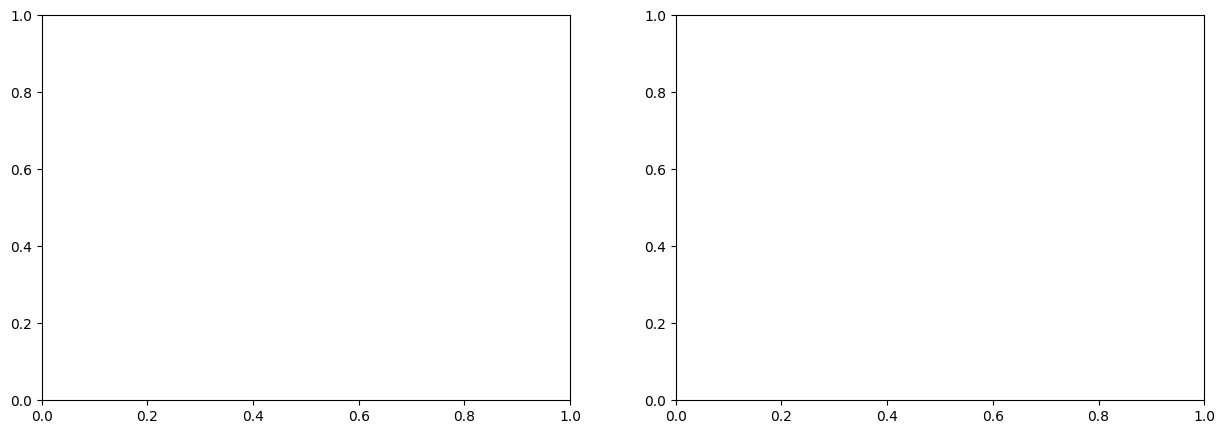

In [18]:
# =============================================================================
# VISUALIZATIONS
# =============================================================================

# 1. Training History - Early Stopping Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

lgb.plot_metric(final_model, metric='logloss', ax=axes[0])
axes[0].set_title('Training History - Early Stopping', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Log Loss', fontsize=12)
axes[0].axvline(x=final_model.best_iteration_, color='red', linestyle='--', label='Best Iteration')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

In [ ]:
# 2. Feature Importance
top_features = feature_importance.head(20)
axes[1].barh(range(len(top_features)), top_features['importance'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance (Gain)', fontsize=12)
axes[1].set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix - Test Set (LightGBM)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Learning Curves
from sklearn.model_selection import learning_curve

print(f"\n{'='*80}")
print("Generating Learning Curves...")
print("="*80)

train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train_scaled, y_train,
    cv=10, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    verbose=0
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, label='Training score', color='darkgreen', marker='o', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='darkgreen')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='orange', marker='s', linewidth=2, markersize=8)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Learning Curves - LightGBM with Overfitting Prevention', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Learning curve analysis
print(f"\n{'='*80}")
print("Learning Curve Analysis:")
print("="*80)
final_train_mean = train_mean[-1]
final_val_mean = val_mean[-1]
gap = final_train_mean - final_val_mean

print(f"Final training score: {final_train_mean:.4f}")
print(f"Final validation score: {final_val_mean:.4f}")
print(f"Gap: {gap:.4f}")

if gap > 0.1:
    print("\n⚠️  High variance/overfitting")
    print("   → Increase reg_alpha/reg_lambda, reduce max_depth")
elif final_val_mean < 0.65:
    print("\n⚠️  High bias/underfitting")
    print("   → Reduce regularization, increase max_depth")
else:
    print("\n✓ Good bias-variance tradeoff!")

In [ ]:
# 5. Stage Comparison
stage_scores = [
    random_search_stage1.best_score_,
    random_search_stage2.best_score_,
    random_search_stage3.best_score_
]
stage_times = [stage1_time/60, stage2_time/60, stage3_time/60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(['Stage 1', 'Stage 2', 'Stage 3'], stage_scores, marker='o', linewidth=3, markersize=12, color='darkgreen')
ax1.set_ylabel('Best CV Score', fontsize=12)
ax1.set_title('LightGBM Optimization Progress', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, score in enumerate(stage_scores):
    ax1.text(i, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

ax2.bar(['Stage 1\n(500 iter)', 'Stage 2\n(2.5K iter)', 'Stage 3\n(5K iter)'], stage_times, color=['#2ca02c', '#ff7f0e', '#d62728'])
ax2.set_ylabel('Time (minutes)', fontsize=12)
ax2.set_title('Time per Stage', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, t in enumerate(stage_times):
    ax2.text(i, t + 1, f'{t:.1f} min', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================
total_time = stage1_time + stage2_time + stage3_time
total_combinations = 500 + 2500 + 5000
total_fits = (500 * 5) + (2500 * 5) + (5000 * 10)

print(f"\n{'='*80}")
print("FINAL SUMMARY - LightGBM WITH OVERFITTING PREVENTION")
print("="*80)
print(f"Total combinations tested: {total_combinations:,}")
print(f"Total model fits: {total_fits:,}")
print(f"Best iteration used: {final_model.best_iteration_} (early stopped)")
print(f"\nTime Breakdown:")
print(f"  Stage 1: {stage1_time/60:.1f} minutes")
print(f"  Stage 2: {stage2_time/60:.1f} minutes")
print(f"  Stage 3: {stage3_time/60:.1f} minutes")
print(f"  Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"\nOptimization Progress:")
print(f"  Stage 1: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2: {random_search_stage2.best_score_:.4f} (+{random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f})")
print(f"  Stage 3: {random_search_stage3.best_score_:.4f} (+{random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f})")
print(f"  Total improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nFinal Performance:")
print(f"  Train accuracy: {train_accuracy:.4f}")
print(f"  Validation accuracy: {val_accuracy:.4f}")
print(f"  Test accuracy: {test_accuracy:.4f}")
print(f"  Train-test gap: {train_accuracy - test_accuracy:.4f}")
print(f"  CV stability (std): {cv_scores.std():.4f}")

print(f"\nAnti-Overfitting Measures Applied:")
print(f"  ✓ Early stopping (stopped at {final_model.best_iteration_}/{best_params['n_estimators']})")
print(f"  ✓ Regularization (L1={best_params['reg_alpha']}, L2={best_params['reg_lambda']})")
print(f"  ✓ Tree complexity limits (depth={best_params['max_depth']}, leaves={best_params['num_leaves']})")
print(f"  ✓ Sampling (subsample={best_params['subsample']}, colsample={best_params['colsample_bytree']})")
print(f"  ✓ Minimum samples (min_child_samples={best_params['min_child_samples']})")
print(f"  ✓ Train-val-test split for monitoring")
print(f"  ✓ Cross-validation for stability")

if test_accuracy > 0.75:
    print(f"\n🏆 Model Performance: OUTSTANDING (>75% accuracy)")
elif test_accuracy > 0.70:
    print(f"\n🎯 Model Performance: EXCELLENT (>70% accuracy)")
elif test_accuracy > 0.65:
    print(f"\n✓ Model Performance: GOOD (>65% accuracy)")
elif test_accuracy > 0.60:
    print(f"\n⚠️  Model Performance: MODERATE (>60% accuracy)")
else:
    print(f"\n❌ Model Performance: NEEDS IMPROVEMENT (<60% accuracy)")

if train_accuracy - test_accuracy <= 0.05:
    print(f"✓ NO OVERFITTING DETECTED!")
else:
    print(f"⚠️  Some overfitting present - consider increasing regularization")

print("\n" + "="*80)
print("3-STAGE LightGBM OPTIMIZATION COMPLETE! 🚀")
print("="*80)